In [1]:
import codecs
import os
import numpy as np
from collections import Counter, OrderedDict
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
import string
import re
from nltk import pos_tag
from nltk.chunk import conlltags2tree
from nltk.tree import Tree
from operator import itemgetter
from nltk import word_tokenize
from nltk.tag.stanford import StanfordNERTagger
from nltk.tag.stanford import StanfordPOSTagger
from sklearn import preprocessing
import json


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_colwidth', -1)

this_journalist = '@colettebrowne'

In [2]:
dirname = '/home/clau/Documents/journal_five_countries/'
classifier = '/usr/share/stanford-ner/classifiers/english.all.3class.distsim.crf.ser.gz'
jar = '/usr/share/stanford-ner/stanford-ner.jar'
st = StanfordNERTagger(classifier,jar)
pos_jar = '/usr/share/stanford-postagger-2017-06-09/stanford-postagger-3.8.0.jar'
tagger = '/usr/share/stanford-postagger-2017-06-09/models/english-bidirectional-distsim.tagger'
spt = StanfordPOSTagger(tagger,pos_jar)

def load_journos_ids():
    journos_file = codecs.open(dirname+'ireland_ids.txt', 'r')
    for line in journos_file:
        journos_ids.append(line.strip())
    journos_file.close()
    return journos_ids

def load_journos_info():
    journos_file = codecs.open(dirname+'irish_journos_info.txt')
    for line in journos_file:
        parts = line.split('\t')
        journos_info['@'+parts[3].lower()] = '@'+parts[3].lower()+'\t'+str(parts[0])+'\t'+parts[1]+'\t'+parts[2]+'\t'+parts[4]+'\t'+parts[5]+'\t'+parts[6].lower()+'\t'+parts[7].strip().lower()
    journos_file.close()
    return journos_info

def populate_mentioned_journos_list():
    #journos_file = codecs.open(dirname+'uk_journos_info.txt')
    mentioned_journos_file = codecs.open(dirname+'mentioned_journalists_ireland.txt')
    mentioned_journos_list = list()
    for line in mentioned_journos_file:
        mentioned_journos_list.append(line.strip())
    mentioned_journos_file.close()
    return mentioned_journos_list

def load_audience_info():
    audience_file = codecs.open(dirname+'audience_descriptions_ireland.txt', 'r')
    audience_description_list = list()
    for line in audience_file:
        audience_description_list.append(line.lower().strip().split('\t'))
    audience_file.close()
    audience_df = pd.DataFrame.from_records(audience_description_list, columns = ['user_id','description','verified','user_name', 'gender','occupation','hobby','salary'])
    return audience_df

def get_interaction_with_journo(journo_name):
    interactions_df = pd.DataFrame(columns=['user_id', 'tweet_text', 'day', 'month', 'hour', 'year'])
    for file1 in os.listdir(dirname+'/audience_tweets_ireland/'):
        this_user_tweets = codecs.open(dirname+'/audience_tweets_ireland/'+file1, 'r')
        for line in this_user_tweets:
            pieces = line.split('\t')
            while len(pieces) < 2:
                line = line.replace('\n', ' ').replace('\r',' ') + next(this_user_tweets)
                pieces = line.split('\t')
            tweet_text = pieces[0]
            tweet_timestamp = pieces[1]
            if journo_name in tweet_text:
                interaction = list()
                interaction.append(file1.replace('.txt',''))
                interaction.append(tweet_text.replace('&amp;', '&'))
                timestamp = tweet_timestamp.strip().split(' ')
                interaction.append(timestamp[0])
                interaction.append(timestamp[1])
                interaction.append(timestamp[3])
                interaction.append(timestamp[5])
                interaction_df = pd.DataFrame(np.array(interaction).reshape(1,6), columns=['user_id', 'tweet_text', 'day', 'month', 'hour', 'year'])
                interactions_df.index = range(1,len(interactions_df)+1)
                interactions_df = interactions_df.append(interaction_df)
        this_user_tweets.close()
    return interactions_df

    #here I just keep the journalists that non-journalists interact with, I ignore the interactions of journalists with other journalists
    def get_interaction_with_other_journos(this_journalist, journo_audience, journos_df):
        j = 0
        interactions_with_others = Counter()
        for file1 in journo_audience:
            if os.path.isfile(dirname+'audience_interactions_ireland/'+file1+'.txt'): 
                this_user_interactions = codecs.open(dirname+'audience_interactions_ireland/'+file1+'.txt', 'r')
                for line in this_user_interactions:
                    pieces = line.split('\t')
                    if pieces[0] in journos_df['user_screen_name'].tolist() and pieces[0] != this_journalist:
                        interactions_with_others[pieces[0]] +=1
                this_user_interactions.close()
            else:
                j+=1
        #print(j)
        return interactions_with_others

    #here I just keep the journalists that non-journalists interact with, I ignore the interactions of journalists with other journalists
    def get_interaction_with_other_categories(this_journalist, journo_audience, journos_df):
        j = 0
        interactions_with_other_categories = Counter()
        for file1 in journo_audience:
            if os.path.isfile(dirname+'audience_interactions_ireland/'+file1+'.txt'): 
                this_user_interactions = codecs.open(dirname+'audience_interactions_ireland/'+file1+'.txt', 'r')
                for line in this_user_interactions:
                    pieces = line.split('\t')
                    if pieces[0] in journos_df['user_screen_name'].tolist() and pieces[0] != this_journalist:
                        interactions_with_other_categories[pieces[4]] += 1
                this_user_interactions.close()
            else:
                j+=1
        #print(j)
        return interactions_with_other_categories

#entity exploration
def extractEntities(interactions_df):
    important_types = ['LOCATION', 'ORGANIZATION', 'PERSON']

    def stanfordNE2tree(ne_tagged_sent):
        bio_tagged_sent = stanfordNE2BIO(ne_tagged_sent)
        if len(bio_tagged_sent) > 0:
            sent_tokens, sent_ne_tags = zip(*bio_tagged_sent)
            sent_pos_tags = [pos for token, pos in pos_tag(sent_tokens)]
            sent_conlltags = [(token, pos, ne) for token, pos, ne in zip(sent_tokens, sent_pos_tags, sent_ne_tags)]
            ne_tree = conlltags2tree(sent_conlltags)
        else:
            ne_tree = 'none'
        return ne_tree

    def stanfordNE2BIO(tagged_sent):
        ntagged_sent = tagged_sent.split(' ')
        bio_tagged_sent = []
        prev_tag = "O"
        x = 0
        while x < len(ntagged_sent)-1:
            tt = ntagged_sent[x].split(',')
            token = tt[0].replace('(', '')
            tag = tt[1].replace(')', '')
            if tag == "O": #O
                bio_tagged_sent.append((token, tag))
                prev_tag = tag
                x+=1
                continue
            if tag != "O" and prev_tag == "O": # Begin NE
                bio_tagged_sent.append((token, "B-"+tag))
                prev_tag = tag
                x+=1
            elif prev_tag != "O" and prev_tag == tag: # Inside NE
                bio_tagged_sent.append((token, "I-"+tag))
                prev_tag = tag
                x+=1
            elif prev_tag != "O" and prev_tag != tag: # Adjacent NE
                bio_tagged_sent.append((token, "B-"+tag))
                prev_tag = tag
                x+=1
        return bio_tagged_sent

    ne_in_sent = Counter()
    tf = Counter()
    total = 0
    
    tweets_texts = interactions_df['tweet_text'].str.replace('[^\w\s]','')
    entities_found = list()
    for t in st.tag(tweets_texts):
        pieces = list(t)
        entities_found.append('('+pieces[0]+','+pieces[1]+')')
    ne_tree = stanfordNE2tree(' '.join(entities_found))
    if ne_tree != 'none':
        for subtree in ne_tree:
            if type(subtree) == Tree: # If subtree is a noun chunk, i.e. NE != "O"
                ne_label = subtree.label()
                #print(ne_label)
                if ne_label in important_types:
                    ne_string = " ".join([token for token, pos in subtree.leaves()])
                    ne_in_sent[ne_string]+=1
    return ne_in_sent

In [3]:
#load journalists' ids and info
journos_ids = list()
journos_info = dict()
journos_ids = load_journos_ids()
journos_info = load_journos_info()

audience_df = load_audience_info()


user_journos = dict()
#load journalists' info
journos_file = codecs.open(dirname+'irish_journos_info.txt')
#load mentioned journalists
mentioned_journos_list = populate_mentioned_journos_list()


#create empty dataframe with headings
all_journos_mentioned = pd.DataFrame(columns=mentioned_journos_list)

def GetJournosDF(journos_info):
    list_of_journos = list()
    for k, v in journos_info.items():
        list_of_journos.append(str(v).split('\t'))

    journos_df = pd.DataFrame(list_of_journos, columns=['user_screen_name', 'user_id', 'org', 'gender', 'category', 'account_type', 'user_name', 'description'])
    return journos_df

journos_df = GetJournosDF(journos_info)

# Get co-occurences

In [4]:
#extract users interactions, create a dataframe for each user and append it to a global dataframe
-

,@adrianweckler,@annesheridan1,@anthonymurnane,@boucherhayes,@brianodtv3,@bryansixone,@caitrionaperry,@carlobrien,@carrollste,@cathalmaccoille,...,@sineadkissane,@siobhanbtv3,@sodonnellnews,@sportsdes,@sullyirishtimes,@tconnellyrte,@tomlyonsbiz,@tonyleen,@viviennetraynor,@willgoodbody
@adrianweckler,0,1,8,52,0,9,0,6,3,2,...,4,1,0,22,2,0,0,5,5,14
@annesheridan1,1,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,2,0
@anthonymurnane,8,0,0,13,0,3,0,1,0,1,...,0,1,0,6,0,0,0,1,4,5
@boucherhayes,52,5,13,0,1,10,1,12,6,8,...,6,2,2,49,1,1,3,9,18,25
@brianodtv3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
@bryansixone,9,0,3,10,0,0,0,2,2,0,...,1,1,0,6,0,0,0,1,3,3
@caitrionaperry,0,0,0,1,0,0,0,2,0,1,...,0,0,0,1,0,0,0,0,0,1
@carlobrien,6,0,1,12,0,2,2,0,2,2,...,2,2,0,4,1,0,0,0,3,5
@carrollste,3,0,0,6,0,2,0,2,0,0,...,1,1,0,0,0,0,0,0,3,2
@cathalmaccoille,2,0,1,8,0,0,1,2,0,0,...,0,0,0,1,0,3,2,1,0,4


In [5]:
df_this_journo_cooc = pd.DataFrame(coocc[this_journalist].reset_index(name='total_interactions')).sort_values(['total_interactions'], ascending=[0])
df_this_journo_cooc = df_this_journo_cooc.loc[df_this_journo_cooc['total_interactions'] > 4]
df_this_journo_cooc = df_this_journo_cooc.rename(columns={'index': 'journalists'})
# f, ax = plt.subplots(figsize=(10, 8))
# int_plot = sns.barplot(x=df_this_journo_cooc['journalist'], y=df_this_journo_cooc['total_interactions'], data=df_this_journo_cooc, ci=None, color='red', orient='v')
df_this_journo_cooc.head(n=5) #this df contains the journo coocurence with other journos, in their interactive users
df1 = df_this_journo_cooc.loc[:, ['journalists']].head(n=5)
df1 = df1.merge(journos_df, left_on='journalists', right_on='user_screen_name', how='inner')
df1 = df1[['journalists','description']]
df1.set_index('journalists',inplace=True)
df1.index.name = None
df1

,description
@gavreilly,"political correspondent at @todayfmnews - but the opinions on man utd, meath gaa, parliaments and pale ale are all mine. rts ≠ endorsements. greilly@todayfm.com"
@harrymcgee,"political correspondent, the irish times @irishtimes. gaeilge. gaa. mountains. film. rith agus cúrsaí reatha. #irishpolitics @irishtimespol"
@boucherhayes,journalist/presenter/author - rté is particularly keen that you should know none of this has anything to do with them.
@oconnellhugh,"political editor @thejournal_ie, occasional journalism lecturer, ex-bbc and newstalk. stories to: hugh@thejournal.ie also found on @tj_politics. views my own."
@patleahysbp,"deputy editor and political editor, sunday business post"


In [6]:
df_this_journo_cooc.head(n=5).to_html(classes='df_this_journo_cooc')

'<table border="1" class="dataframe df_this_journo_cooc">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>journalists</th>\n      <th>total_interactions</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>36</th>\n      <td>@gavreilly</td>\n      <td>289</td>\n    </tr>\n    <tr>\n      <th>37</th>\n      <td>@harrymcgee</td>\n      <td>178</td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td>@boucherhayes</td>\n      <td>165</td>\n    </tr>\n    <tr>\n      <th>58</th>\n      <td>@oconnellhugh</td>\n      <td>137</td>\n    </tr>\n    <tr>\n      <th>62</th>\n      <td>@patleahysbp</td>\n      <td>114</td>\n    </tr>\n  </tbody>\n</table>'

# Plot co-occurences

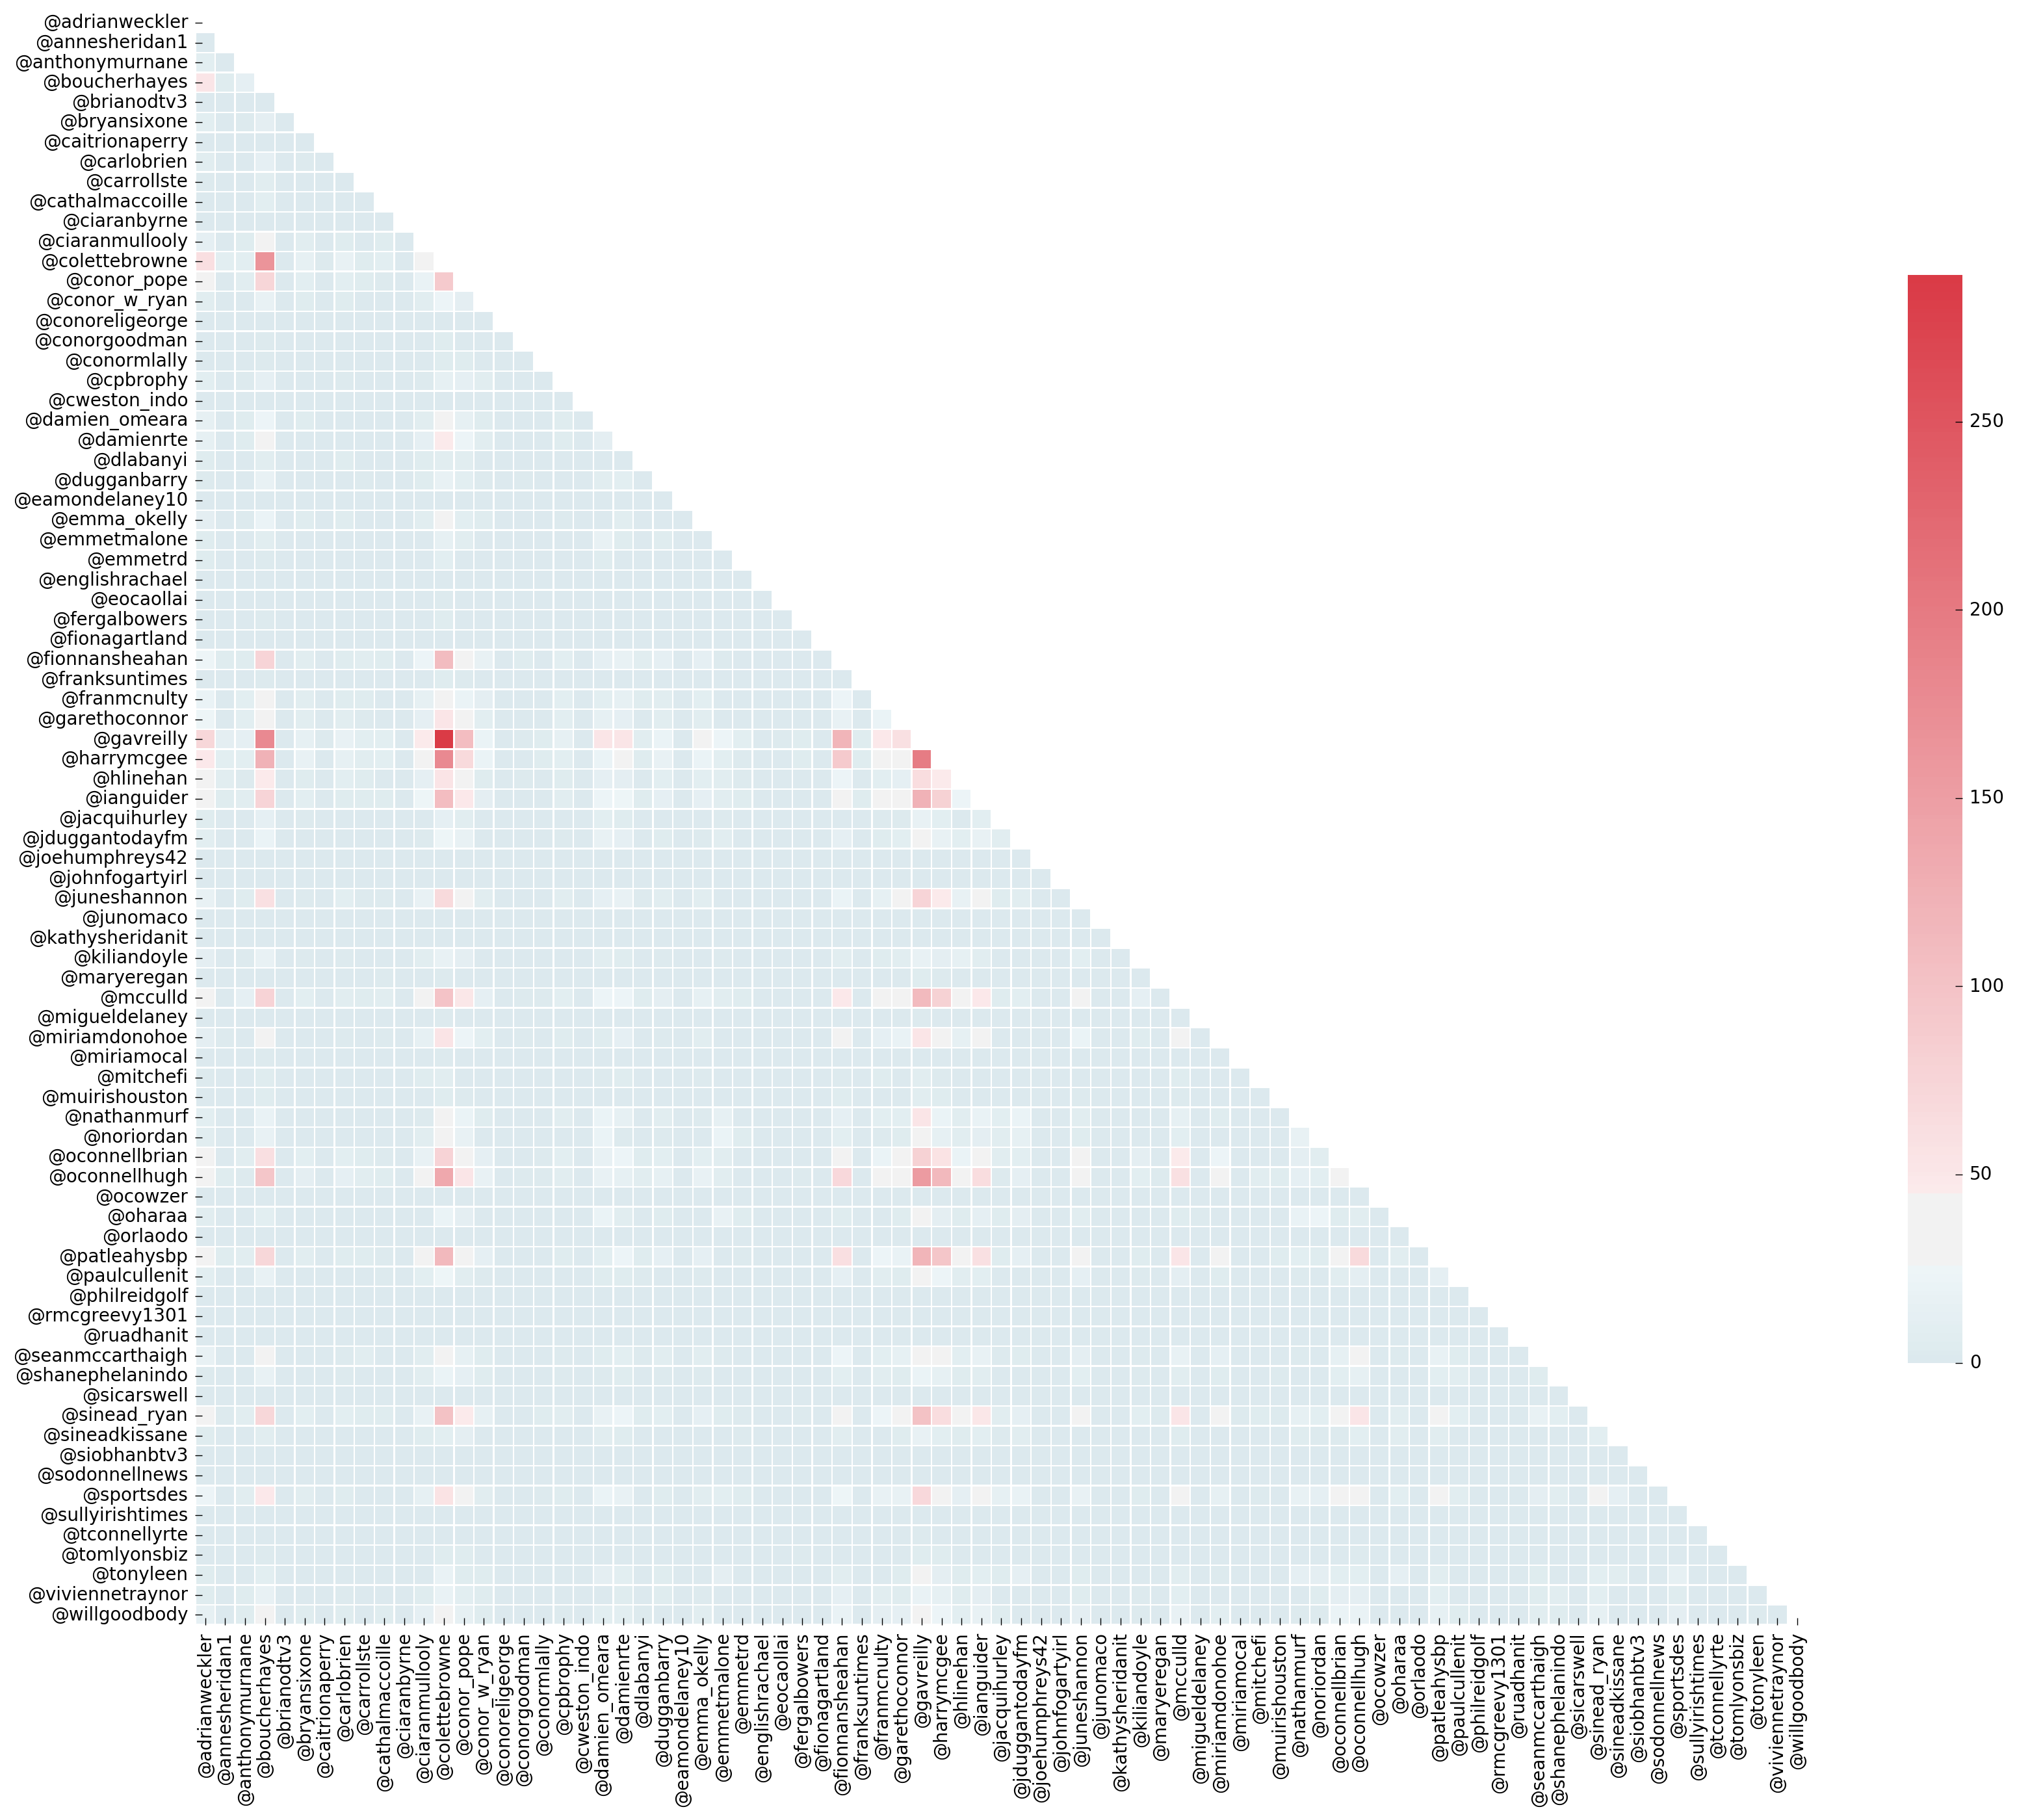

In [29]:
#Generate a mask for the upper triangle
mask = np.zeros_like(coocc, dtype=np.int)
mask[np.triu_indices_from(mask)] = True

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

#Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(coocc, mask=mask, cmap=cmap, vmax=coocc.values.max(), center=35,
            square=True, linewidths=.5, cbar_kws={"shrink": .6})

In [8]:
def get_interaction_with_journo(journo_name):
    interactions_df = pd.DataFrame(columns=['user_id', 'tweet_text', 'day', 'month', 'hour', 'year'])
    for file1 in os.listdir(dirname+'/audience_tweets_ireland/'):
        this_user_tweets = codecs.open(dirname+'/audience_tweets_ireland/'+file1, 'r')
        for line in this_user_tweets:
            pieces = line.split('\t')
            while len(pieces) < 2:
                line = line.replace('\n', ' ').replace('\r',' ') + next(this_user_tweets)
                pieces = line.split('\t')
            tweet_text = pieces[0]
            tweet_timestamp = pieces[1]
            if journo_name in tweet_text:
                interaction = list()
                interaction.append(file1.replace('.txt',''))
                interaction.append(tweet_text.replace('&amp;', '&'))
                timestamp = tweet_timestamp.strip().split(' ')
                interaction.append(timestamp[0])
                interaction.append(timestamp[1])
                interaction.append(timestamp[3])
                interaction.append(timestamp[5])
                interaction_df = pd.DataFrame(np.array(interaction).reshape(1,6), columns=['user_id', 'tweet_text', 'day', 'month', 'hour', 'year'])
                interactions_df.index = range(1,len(interactions_df)+1)
                interactions_df = interactions_df.append(interaction_df)
        this_user_tweets.close()
    return interactions_df

#here I just keep the journalists that non-journalists interact with, I ignore the interactions of journalists with other journalists
def get_interaction_with_other_journos(this_journalist, journo_audience, journos_df):
    j = 0
    interactions_with_others = Counter()
    for file1 in journo_audience:
        if os.path.isfile(dirname+'audience_interactions_ireland/'+file1+'.txt'): 
            this_user_interactions = codecs.open(dirname+'audience_interactions_ireland/'+file1+'.txt', 'r')
            for line in this_user_interactions:
                pieces = line.split('\t')
                if pieces[0] in journos_df['user_screen_name'].tolist() and pieces[0] != this_journalist:
                    interactions_with_others[pieces[0]] +=1
            this_user_interactions.close()
        else:
            j+=1
    #print(j)
    return interactions_with_others

#here I just keep the journalists that non-journalists interact with, I ignore the interactions of journalists with other journalists
def get_interaction_with_other_categories(this_journalist, journo_audience, journos_df):
    j = 0
    interactions_with_other_categories = Counter()
    for file1 in journo_audience:
        if os.path.isfile(dirname+'audience_interactions_ireland/'+file1+'.txt'): 
            this_user_interactions = codecs.open(dirname+'audience_interactions_ireland/'+file1+'.txt', 'r')
            for line in this_user_interactions:
                pieces = line.split('\t')
                if pieces[0] in journos_df['user_screen_name'].tolist() and pieces[0] != this_journalist:
                    interactions_with_other_categories[pieces[4]] += 1
            this_user_interactions.close()
        else:
            j+=1
    #print(j)
    return interactions_with_other_categories

In [9]:
interactions_df = get_interaction_with_journo(this_journalist)
interactions_df['hour'] = interactions_df['hour'].apply(lambda x: (x[:2]))
interactions_df['hour'] = pd.to_numeric(interactions_df['hour'])
interactions_df['block'] = np.where(interactions_df['hour'] >= 18, 'evening',(np.where((interactions_df['hour'] >= 12)&(interactions_df['hour'] < 18),'afternoon', 'morning')))
interactions_df

,user_id,tweet_text,day,month,hour,year,block
1,25718192,@colettebrowne read it over me Rice Krispies this morning. Excellent piece.,Tue,Oct,19,2015,evening
2,25718192,@colettebrowne @Concern good luck Colette. Look forward to reading your reports.,Tue,Sep,15,2015,afternoon
3,4451242096,@colettebrowne @Independent_ie Law does not applies to rich & the powerful,Fri,Jan,11,2016,morning
4,4451242096,@colettebrowne @Robert_Ranson,Sun,Feb,18,2016,evening
5,119870612,@colettebrowne that's Brilliant lets RT,Sun,Dec,11,2015,morning
6,119870612,@colettebrowne that's brilliant he is no Pole dancer 😃,Thu,Dec,22,2015,evening
7,119870612,@colettebrowne you would have to ask why didn't the Ad include a Man and a Woman ? Why risk such a backlash so close to the General Election,Sun,Jan,12,2016,afternoon
8,119870612,@colettebrowne its a disgrace,Wed,Mar,17,2016,afternoon
9,119870612,@colettebrowne how about agony Uncle @MHealyRae and his brother made a lot of sense today in the Dail.,Fri,Mar,0,2016,morning
10,193753,@colettebrowne Glad I saw this post event!,Thu,Oct,20,2015,evening


In [10]:
#select unique users who interacted with journalist and how many times they interacted
df_num_interactions = interactions_df.groupby(['user_id'])['user_id'].count().reset_index(name='number_interactions')
#df_num_interactions = df_num_interactions.sort_values(['number_interactions'], ascending=[0])
df_num_interactions['quantile'] = pd.cut(df_num_interactions['number_interactions'],4)
df_num_interactions['quantile_std_name'] = pd.cut(df_num_interactions['number_interactions'],4, labels=['q1', 'q2', 'q3', 'q4'])
df_num_interactions['max_interactions'] = 0
df_num_interactions['max_interactions'] = df_num_interactions.apply(lambda x: x['max_interactions'] + round(float(x['quantile'].replace(']', '').split(',')[1])), axis=1)
df_num_interactions

,user_id,number_interactions,quantile,quantile_std_name,max_interactions
0,1000713217,1,"(0.926, 19.5]",q1,20
1,1007716344,18,"(0.926, 19.5]",q1,20
2,1008640118,13,"(0.926, 19.5]",q1,20
3,1012824824,7,"(0.926, 19.5]",q1,20
4,101734251,1,"(0.926, 19.5]",q1,20
5,102089809,24,"(19.5, 38]",q2,38
6,102913505,4,"(0.926, 19.5]",q1,20
7,1045183711,1,"(0.926, 19.5]",q1,20
8,104876737,19,"(0.926, 19.5]",q1,20
9,107396736,5,"(0.926, 19.5]",q1,20


In [11]:
print(str(interactions_df['user_id'].nunique())+' users interacted with you between Sept. 2015 and May 2016')

323 users interacted with you between Sept. 2015 and May 2016


In [12]:
#get number of users who interacted n times with the journo
df_num_interactions1 = audience_df.merge(df_num_interactions, left_on='user_id', right_on='user_id', how='inner')
df_num_interactions1 = df_num_interactions1[['user_id','number_interactions','quantile','quantile_std_name','max_interactions','gender']]
df_num_interactions1 = df_num_interactions1.dropna(how='any')
df_num_interactions1
df_num_interactions_female = df_num_interactions1.loc[df_num_interactions1['gender']=='female']
df_num_interactions_male = df_num_interactions1.loc[df_num_interactions1['gender']=='male']
df_users_by_num_interactions_male = df_num_interactions_male.groupby(['number_interactions'])['user_id'].count().reset_index(name='male')
df_users_by_num_interactions_female = df_num_interactions_female.groupby(['number_interactions'])['user_id'].count().reset_index(name='female')
df_users_by_num_interactions = df_users_by_num_interactions_male.merge(df_users_by_num_interactions_female, left_on='number_interactions', right_on='number_interactions', how='outer')
df_users_by_num_interactions.sort_values(['number_interactions'], ascending=[0])
df_users_by_num_interactions['quantile'] = pd.cut(df_users_by_num_interactions['number_interactions'],4)
df_users_by_num_interactions['quantile_std_name'] = pd.cut(df_users_by_num_interactions['number_interactions'],4, labels=['q1', 'q2', 'q3', 'q4'])
df_users_by_num_interactions['max_interactions'] = 0
df_users_by_num_interactions['max_interactions'] = df_users_by_num_interactions.apply(lambda x: x['max_interactions'] + round(float(x['quantile'].replace(']', '').split(',')[1])), axis=1)
df_users_by_num_interactions['female'] = df_users_by_num_interactions.female.fillna(0)
df_users_by_num_interactions['male'] =df_users_by_num_interactions.male.fillna(0)
df_users_by_num_interactions
#df_user_groups = df_users_by_num_interactions.groupby(['max_interactions','quantile_std_name'])['number_users'].sum().reset_index(name='total_users')
df_user_groups1 = df_users_by_num_interactions.groupby(['max_interactions'])['male'].sum().reset_index(name='male')
df_user_groups2 = df_users_by_num_interactions.groupby(['quantile_std_name'])['male'].sum().reset_index(name='male')
df_user_groups_male = df_user_groups1.merge(df_user_groups2, left_on='male', right_on='male', how='outer')
df_user_groups1 = df_users_by_num_interactions.groupby(['max_interactions'])['female'].sum().reset_index(name='female')
df_user_groups2 = df_users_by_num_interactions.groupby(['quantile_std_name'])['female'].sum().reset_index(name='female')
df_user_groups_female = df_user_groups1.merge(df_user_groups2, left_on='female', right_on='female', how='outer')
df_user_groups_female
df_user_groups1 = df_user_groups_male.merge(df_user_groups_female, left_on=['max_interactions','quantile_std_name'], right_on=['max_interactions','quantile_std_name'], how='outer')
df_user_groups = df_user_groups1.dropna(how='any')
df_user_groups['total_users'] = 0
df_user_groups['total_users'] = df_user_groups.apply(lambda x: x['total_users'] + x['male'] + x['female'], axis=1)
df_user_groups
df_num_interactions1

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,user_id,number_interactions,quantile,quantile_std_name,max_interactions,gender
0,3003515385,30,"(19.5, 38]",q2,38,female
1,82444899,1,"(0.926, 19.5]",q1,20,female
2,315468577,12,"(0.926, 19.5]",q1,20,female
3,2788295746,3,"(0.926, 19.5]",q1,20,male
4,228066656,1,"(0.926, 19.5]",q1,20,male
5,2468349552,6,"(0.926, 19.5]",q1,20,female
6,2933917781,2,"(0.926, 19.5]",q1,20,female
7,18745483,11,"(0.926, 19.5]",q1,20,male
8,763627830,7,"(0.926, 19.5]",q1,20,male
9,1171393471,3,"(0.926, 19.5]",q1,20,male


In [13]:
#sns.barplot(x=df_user_groups['max_interactions'], y=df_user_groups['total_users'], data=df_user_groups, ci=None, palette=sns.light_palette('red', n_colors=4))

In [14]:
quartile = 'q1'
#load journos info
# list_of_journos = list()
# for k, v in journos_info.items():
#     list_of_journos.append(str(v).split('\t'))

# journos_df = pd.DataFrame(list_of_journos, columns=['user_screen_name', 'user_id', 'org', 'gender', 'category', 'account_type', 'user_name', 'description'])
# journos_df

In [15]:
audience_df

,user_id,description,verified,user_name,gender,occupation,hobby,salary
0,220725381,"interested in environment, energy, frugal innovation.",false,rose sharp,female,none,interested in environment energy frugal innovation,none
1,314048832,'i''m probably not going to read that book you recommended.',false,neil,male,none,none,none
2,3003515385,fine gaeler. psephologist. contrarian. compulsive book-buyer. happiest at cinema or opera. views expressed here are most definitely mine and mine alone.,false,barry walsh,female,psephologist,compulsive book buyer happiest at cinema or opera views expressed here are most definitely mine and mine alone,between 50k and 100k
3,82444899,always someone worse off than yourself. i will keep on fighting for my beloved ireland....,false,eileen roche,female,none,none,none
4,315468577,"president of waterford council of trade unions,member of tu to repeal the 8th. lone parent to six,youthreach teachr only use twitter when provoked...views mine.",false,una dunphy,female,none,parent to six,none
5,57148450,journalist with the irish times.,false,kathy sheridan,female,journalist,none,<50k
6,2788295746,none,false,dissident,male,none,none,none
7,22938752,"keyboard/piano with galway band tightrope, lfc supporter, athlone and westmeath gaa supporter.",false,jimmy allen,male,none,lfc supporter gaa supporter,none
8,2322466020,"recreational runner, sometime hillwalker, irish expat in brussels",false,enda ryan,male,none,none,none
9,228066656,lefty-euro-atheist-veggie. ex-blogger. runs. likes cricket science & economics. dad to 4 husband to 1. sex positive. former bi/poly activist.known to compromise,false,irishpollingreport,male,none,likes cricket science economics parent to 4 spouse to 1 sex positive former bi poly activist known to compromise,none


In [16]:
#info of users, including quartile of interactions
new_df_num_interactions = df_num_interactions1[['user_id','quantile_std_name','gender']]
joined_df = new_df_num_interactions.set_index('user_id').join(audience_df.set_index('user_id'), lsuffix='_1', rsuffix='_2')
joined_df = joined_df.rename(columns={'gender_1': 'gender'})
joined_df = joined_df.drop('gender_2', 1)
joined_df

,quantile_std_name,gender,description,verified,user_name,occupation,hobby,salary
user_id,,,,,,,,
3003515385,q2,female,fine gaeler. psephologist. contrarian. compulsive book-buyer. happiest at cinema or opera. views expressed here are most definitely mine and mine alone.,false,barry walsh,psephologist,compulsive book buyer happiest at cinema or opera views expressed here are most definitely mine and mine alone,between 50k and 100k
82444899,q1,female,always someone worse off than yourself. i will keep on fighting for my beloved ireland....,false,eileen roche,none,none,none
315468577,q1,female,"president of waterford council of trade unions,member of tu to repeal the 8th. lone parent to six,youthreach teachr only use twitter when provoked...views mine.",false,una dunphy,none,parent to six,none
2788295746,q1,male,none,false,dissident,none,none,none
228066656,q1,male,lefty-euro-atheist-veggie. ex-blogger. runs. likes cricket science & economics. dad to 4 husband to 1. sex positive. former bi/poly activist.known to compromise,false,irishpollingreport,none,likes cricket science economics parent to 4 spouse to 1 sex positive former bi poly activist known to compromise,none
2468349552,q1,female,'happy with humans. all views this human''s own. retweets according to alignment of planets.',false,'gerry o''meara',none,none,none
2933917781,q1,female,none,false,ruth hegarty,none,none,none
18745483,q1,male,"information quality, info gov & data protection consultant, writer, teacher, family guy #iqcp certified. personal blog: http://obriend.info",false,daragh o brien,teacher,none,between 50k and 100k
763627830,q1,male,"'science, politics, sport, news junkie, allergic to cronyism and the ''golden circle''. voting independent. rts not endorsement. dublin, sligo.'",false,mgrey,none,news junkie,none


In [17]:
#entity exploration
def extractEntities(interactions_df):
        important_types = ['LOCATION', 'ORGANIZATION', 'PERSON']

        def stanfordNE2tree(ne_tagged_sent):
            bio_tagged_sent = stanfordNE2BIO(ne_tagged_sent)
            if len(bio_tagged_sent) > 0:
                sent_tokens, sent_ne_tags = zip(*bio_tagged_sent)
                sent_pos_tags = [pos for token, pos in pos_tag(sent_tokens)]
                sent_conlltags = [(token, pos, ne) for token, pos, ne in zip(sent_tokens, sent_pos_tags, sent_ne_tags)]
                ne_tree = conlltags2tree(sent_conlltags)
            else:
                ne_tree = 'none'
            return ne_tree

        def stanfordNE2BIO(tagged_sent):
            ntagged_sent = tagged_sent.split(' ')
            bio_tagged_sent = []
            prev_tag = "O"
            x = 0
            while x < len(ntagged_sent)-1:
                tt = ntagged_sent[x].split(',')
                token = tt[0].replace('(', '')
                tag = tt[1].replace(')', '')
                if tag == "O": #O
                    bio_tagged_sent.append((token, tag))
                    prev_tag = tag
                    x+=1
                    continue
                if tag != "O" and prev_tag == "O": # Begin NE
                    bio_tagged_sent.append((token, "B-"+tag))
                    prev_tag = tag
                    x+=1
                elif prev_tag != "O" and prev_tag == tag: # Inside NE
                    bio_tagged_sent.append((token, "I-"+tag))
                    prev_tag = tag
                    x+=1
                elif prev_tag != "O" and prev_tag != tag: # Adjacent NE
                    bio_tagged_sent.append((token, "B-"+tag))
                    prev_tag = tag
                    x+=1
            return bio_tagged_sent

        ne_in_sent = Counter()
        tf = Counter()
        total = 0

        tweets_texts = interactions_df['tweet_text'].str.replace('[^\w\s]','')
        entities_found = list()
        for t in st.tag(tweets_texts):
            pieces = list(t)
            entities_found.append('('+pieces[0]+','+pieces[1]+')')
        ne_tree = stanfordNE2tree(' '.join(entities_found))
        if ne_tree != 'none':
            for subtree in ne_tree:
                if type(subtree) == Tree: # If subtree is a noun chunk, i.e. NE != "O"
                    ne_label = subtree.label()
                    #print(ne_label)
                    if ne_label in important_types:
                        ne_string = " ".join([token for token, pos in subtree.leaves()])
                        ne_in_sent[ne_string]+=1
        return ne_in_sent

In [18]:
#filtro los tweets dependiendo del bloque de usuarios que este analizando y encuentro entidades
new_interactions_df = new_df_num_interactions.set_index('user_id').join(interactions_df.set_index('user_id'))
new_interactions_df
for e,v in extractEntities(new_interactions_df.loc[new_interactions_df['quantile_std_name'] == quartile]).items():
    print(e+','+str(v))

EC,1
Irish Times IPSOSMRBI,1
Denis Landy,1
Garda,1
Dublin,1
Bruton,1
Colette,1
Harney,1
Ireland,1
Martin Harney Reilly,1
Mick,1
General Election,1
Ruth Dourly Jedwards,1
RTE,1
Marylou,1
Yates,1
EU,2
Joe,1
Cahill,2
Dennis O Brien,1
Seanad,1
Dáil,1
GE,1
Kelly,1
Masserine,1
France,2
Dennis,1
Kenny,1


# Plot Popular days, months, hours

,quantile_std_name,gender,tweet_text,day,month,hour,year,block
user_id,,,,,,,,
1000713217,q1,male,@colettebrowne @Jim_Sheridan @Independent_ie great title,Tue,Feb,13,2016,afternoon
1007716344,q1,female,@colettebrowne @Isfeidirliom @FineGael @SaturdayRTE were Dé Valera and co questioned in and around 1936 re Rising and Civil War Murders?,Sun,Dec,20,2015,evening
1007716344,q1,female,"@colettebrowne @Isfeidirliom @FineGael @SaturdayRTE no , but an RNU member was 'elected to Seanad; questions re PC Kerr 2010 RIP absolutely.",Sun,Dec,20,2015,evening
1007716344,q1,female,@colettebrowne @Isfeidirliom No wish 2 compare any murders;each is an irreplaceable loss; querying the questioning of candidates/politicians,Sun,Dec,21,2015,evening
1007716344,q1,female,@colettebrowne @Isfeidirliom Civil War murders were indeed horrific though; including a TD on way to Dáil and 7 year old son of another TD.,Sun,Dec,21,2015,evening
1007716344,q1,female,"@colettebrowne @SeosamhMagAodha @Iconoclast70 @justin_casey_84 @brianmlucey @SaturdayRTE nonsense, SF Dáil candidate's father was Garda also",Sat,Dec,15,2015,afternoon
1007716344,q1,female,@colettebrowne @SaturdayRTE refused to condemn or rejected the premise of the question?,Sat,Dec,15,2015,afternoon
1007716344,q1,female,"@colettebrowne @SeosamhMagAodha @Iconoclast70 @justin_casey_84 @brianmlucey @SaturdayRTE no, that would be Labour/Rnu; SF peace supporters",Sat,Dec,15,2015,afternoon
1007716344,q1,female,@colettebrowne @SaturdayRTE have you asked Senator Cahill to condemn the murder of 2 soldiers Masserine and a police officer in 2009/10?,Sat,Dec,15,2015,afternoon


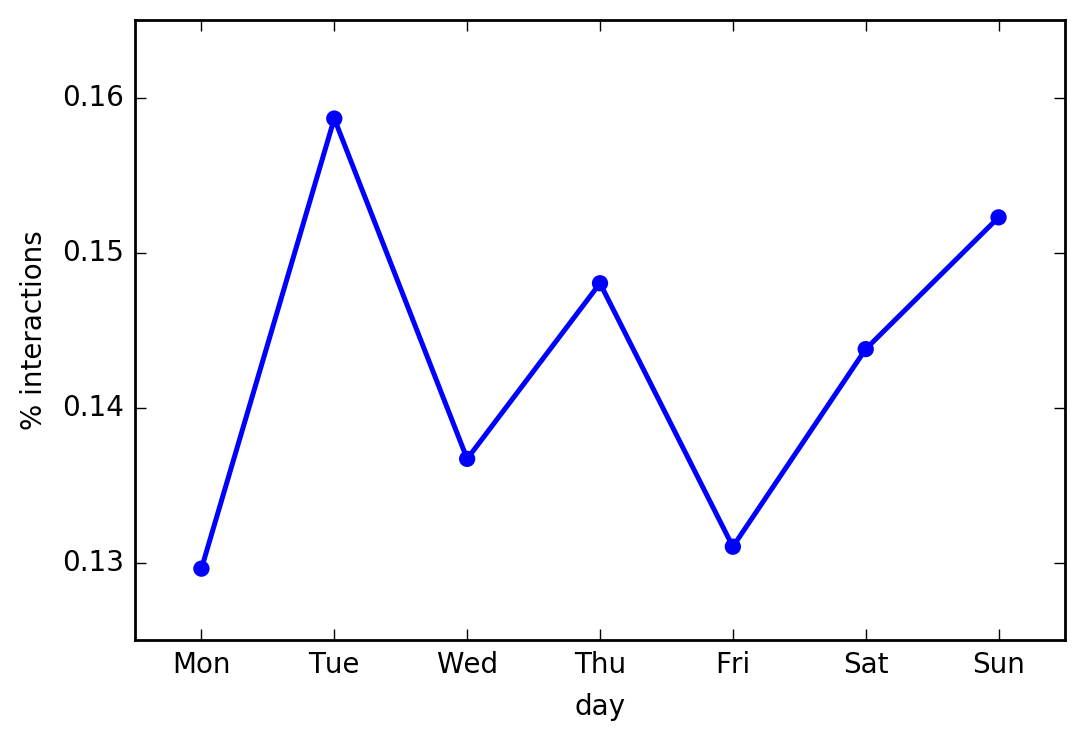

In [19]:
#all is filtered by quartile
new_day_df = pd.DataFrame(index=[0,1,2,3,4,5,6,], columns=['day','% interactions'])
new_day_df['day'] = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
new_day_df['% interactions'] = [0,0,0,0,0,0,0]
day_df = new_interactions_df.loc[new_interactions_df['quantile_std_name'] == quartile].groupby(['day'])['tweet_text'].count().reset_index(name='% interactions')
day_df['% interactions'] = day_df['% interactions'].apply(lambda x: (x / day_df['% interactions'].sum()))
days_df = new_day_df[['day', '% interactions']].set_index('day')
days_df.update(day_df.set_index('day'))
new_day_df['% interactions'] = days_df.values
#plot
lp = sns.pointplot(x=new_day_df['day'], y=new_day_df['% interactions'], data=new_day_df)
#lp.set(ylim=(0, None))
lp
new_interactions_df

In [20]:
interactions = np.where(df_num_interactions['quantile_std_name'] == quartile, df_num_interactions['max_interactions'], 0).max()
if quartile == 'q1':
    print('People who interacted with you up to '+ str(interactions) +' times were most active on '+str(new_day_df.loc[new_day_df['% interactions'].argmax(), 'day']))
else:
    interactions_two = np.where(df_num_interactions['quantile_std_name'] == 'q'+str(int(quartile[1:2])-1), df_num_interactions['max_interactions'], 0).max()
    print('People who interacted with you between '+ str(interactions_two)+' and '+str(interactions) +' times were most active on '+str(new_day_df.loc[new_day_df['% interactions'].argmax(), 'day']))

People who interacted with you up to 20 times were most active on Tue


In [21]:
#month analysis, inactive at the moment
# month_df = new_interactions_df.loc[new_interactions_df['quantile_std_name'] == quartile].groupby(['month'])['tweet_text'].count().reset_index(name='number_interactions')
# month_df['number_interactions'] = month_df['number_interactions'].apply(lambda x: (x / month_df['number_interactions'].sum()))
# sns.pointplot(x=day_df['day'], y=day_df['number_interactions'], data=day_df)

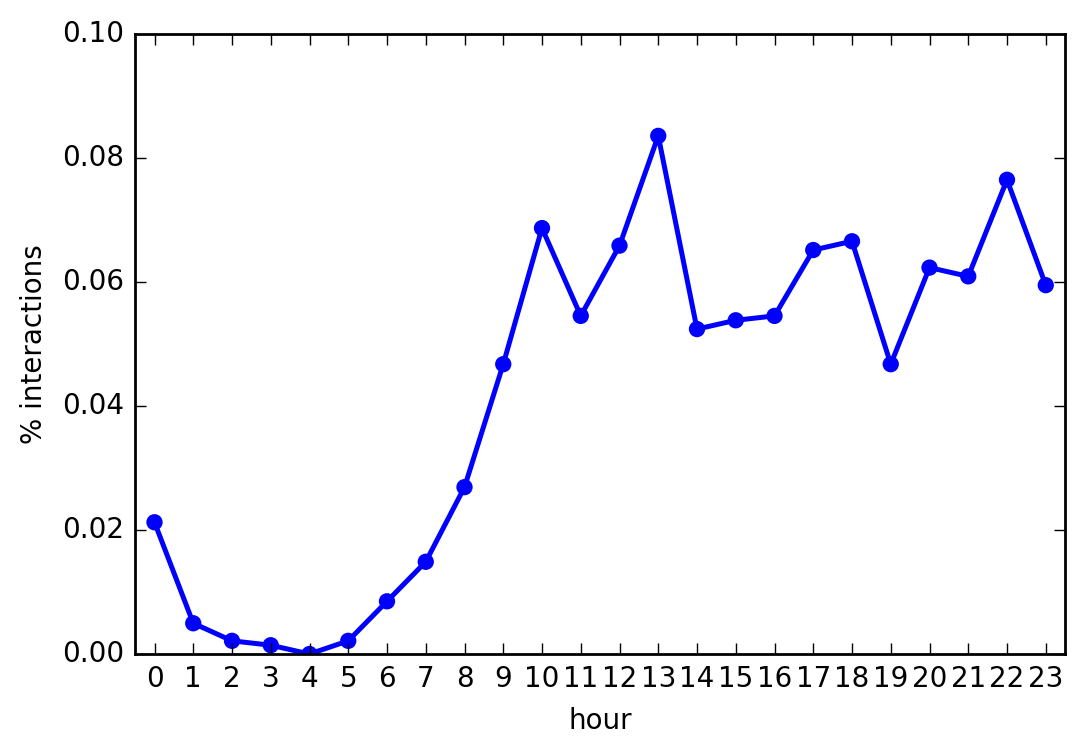

In [22]:
new_hour_df = pd.DataFrame(index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], columns=['hour','% interactions'])
new_hour_df['hour'] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
new_hour_df['% interactions'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
hour_df = new_interactions_df.loc[new_interactions_df['quantile_std_name'] == quartile].groupby(['hour'])['tweet_text'].count().reset_index(name='% interactions')
hour_df['% interactions'] = hour_df['% interactions'].apply(lambda x: (x / hour_df['% interactions'].sum()))
hours_df = new_hour_df[['hour', '% interactions']].set_index('hour')
hours_df.update(hour_df.set_index('hour'))
new_hour_df['% interactions'] = hours_df.values
#plot
lp = sns.pointplot(x=new_hour_df['hour'], y=new_hour_df['% interactions'], data=new_hour_df)
lp.set(ylim=(0, None))
lp

In [23]:
block_df = new_interactions_df.loc[new_interactions_df['quantile_std_name'] == quartile].groupby(['block'])['tweet_text'].count().reset_index(name='% interactions')
block_df['% interactions'] = block_df['% interactions'].apply(lambda x: (x / block_df['% interactions'].sum()))

if quartile == 'q1':
    print('People who interacted with you up to '+str(interactions) +' times, did so mostly in the '+str(block_df.loc[block_df['% interactions'].argmax(), 'block']))
else:
    interactions_two = np.where(df_num_interactions['quantile_std_name'] == 'q'+str(int(quartile[1:2])-1), df_num_interactions['max_interactions'], 0).max()
    print('People who interacted with you between '+ str(interactions_two)+' and '+str(interactions) +' times, did so mostly in the '+str(block_df.loc[block_df['% interactions'].argmax(), 'block']))

People who interacted with you up to 20 times, did so mostly in the afternoon


# Extract occupation, salary?, and age?

In [24]:
#Detailed level of occupations used in the SOC2010-based census: http://www.cso.ie/en/media/csoie/census/documents/census2011profile3/Profile_3full_doc_for_web_sig_amended.pdf page 79
#returns 97 occupations of which 95 are relevant while failing to return 16 additional relevant occupations, its precision is 95/97=0.98 while its recall is 95/113=0.84
#returns 76 occupations of which 73 are relevant while failing to return 30 additional relevant occupations, its precision is 73/76=0.96 while its recall is 73/106=0.70

#salary = http://www.payscale.com/rcsearch.aspx?country=IE&str=Writer
# classification
# ndf = joined_df.loc[joined_df['quantile_std_name'] == quartile]
# translator = str.maketrans('', '', string.punctuation)
# dscrptn = ' '.join(ndf['description'])
# dscrptn = dscrptn.translate(translator)
# print(spt.tag(dscrptn.split()))

# What other journos are they interested in?

In [25]:
ndf = joined_df.loc[joined_df['quantile_std_name'] == quartile]
gender_dict = Counter()
org_dict =  Counter()
ndf = ndf.reset_index(drop=False)
print(ndf.to_json)
relevant_journos = get_interaction_with_other_journos(this_journalist, ndf['user_id'].tolist(), journos_df)
sorted_journos = relevant_journos.most_common()
for k, v in sorted_journos:
    print(k+' '+str(v))
    journos_df.loc[journos_df['user_screen_name'] == k, 'description'].item()
    gender_dict[journos_df.loc[journos_df['user_screen_name'] == k, 'gender'].item()]+=1
    org_dict[journos_df.loc[journos_df['user_screen_name'] == k, 'org'].item()]+=1
#gender of other journalists whom your audience interacted with
print('=======================')
for k, v in gender_dict.most_common():
    print(k+' '+str(v))
#orgs your audience interacted with, appart from yours
print('=======================')
for k, v in org_dict.most_common():
    print(k+' '+str(v))

<bound method NDFrame.to_json of         user_id quantile_std_name  gender  \
0    82444899    q1                female   
1    315468577   q1                female   
2    2788295746  q1                male     
3    228066656   q1                male     
4    2468349552  q1                female   
5    2933917781  q1                female   
6    18745483    q1                male     
7    763627830   q1                male     
8    1171393471  q1                male     
9    3303803926  q1                male     
10   1469451456  q1                male     
11   119494687   q1                male     
12   220729806   q1                male     
13   502272875   q1                male     
14   3235403947  q1                male     
15   3032618085  q1                female   
16   134092014   q1                male     
17   6296892     q1                male     
18   619320698   q1                male     
19   96606961    q1                female   
20   258087848   q1   

# What other categories are they interested in?

In [26]:
ndf = joined_df.loc[joined_df['quantile_std_name'] == quartile]
ndf = ndf.reset_index(drop=False)
for k, v in get_interaction_with_other_categories(this_journalist, ndf['user_id'].tolist(), journos_df).most_common():
    print(k+' '+str(v))

politics 15308
breaking_news 4631
lifestyle 2969
sports 1463
sci&tech 1156
business 1024


# Overall (not per quartile) day when people interact the most with this journo

In [69]:
overall_day_df_male = pd.DataFrame(index=[0,1,2,3,4,5,6,], columns=['day','male'])
overall_day_df_male['day'] = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
overall_day_df_male['male'] = [0,0,0,0,0,0,0]
new_interactions_df_male = new_interactions_df.loc[new_interactions_df['gender']=='male']
t_day_df_male = new_interactions_df_male.groupby(['day'])['tweet_text'].count().reset_index(name='male')
t_day_df_male['male'] = t_day_df_male['male'].apply(lambda x: (x / t_day_df_male['male'].sum()))
t_days_df_male = overall_day_df_male[['day', 'male']].set_index('day')
t_days_df_male.update(t_day_df_male.set_index('day'))
overall_day_df_male['male'] = t_days_df_male.values

overall_day_df_female = pd.DataFrame(index=[0,1,2,3,4,5,6,], columns=['day','female'])
overall_day_df_female['day'] = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
overall_day_df_female['female'] = [0,0,0,0,0,0,0]
new_interactions_df_female = new_interactions_df.loc[new_interactions_df['gender']=='female']
t_day_df_female = new_interactions_df_female.groupby(['day'])['tweet_text'].count().reset_index(name='female')
t_day_df_female['female'] = t_day_df_female['female'].apply(lambda x: (x / t_day_df_female['female'].sum()))
t_days_df_female = overall_day_df_female[['day', 'female']].set_index('day')
t_days_df_female.update(t_day_df_female.set_index('day'))
overall_day_df_female['female'] = t_days_df_female.values
new_day_df = overall_day_df_female.merge(overall_day_df_male, left_on=['day'], right_on=['day'], how='outer')
new_day_df
#plot
#lp = sns.pointplot(x=new_day_df['day'], y=new_day_df['% interactions'], data=new_day_df)
#lp.set(ylim=(0, None))
#lp

,day,female,male
0,Mon,0.158798,0.120980
1,Tue,0.165236,0.171516
2,Wed,0.137339,0.136294
3,Thu,0.143777,0.143441
4,Fri,0.135193,0.129658
5,Sat,0.130901,0.150587
6,Sun,0.128755,0.147524


In [71]:
print('People who interacted with you, did so mostly on '+str(new_day_df.loc[new_day_df['male'].argmax(), 'day']))

People who interacted with you, did so mostly on Tue


# Overall (not per quartile) block when people interact the most with this journo

In [72]:
# new_hour_df = pd.DataFrame(index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], columns=['hour','% interactions'])
# new_hour_df['hour'] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
# new_hour_df['% interactions'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
# hour_df = new_interactions_df.groupby(['hour'])['tweet_text'].count().reset_index(name='% interactions')
# hour_df['% interactions'] = hour_df['% interactions'].apply(lambda x: (x / hour_df['% interactions'].sum()))
# hours_df = new_hour_df[['hour', '% interactions']].set_index('hour')
# hours_df.update(hour_df.set_index('hour'))
# new_hour_df['% interactions'] = hours_df.values
# #plot
# lp = sns.pointplot(x=new_hour_df['hour'], y=new_hour_df['% interactions'], data=new_hour_df)
# lp.set(ylim=(0, None))
# lp
# new_hour_df

overall_hour_df_male = pd.DataFrame(index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], columns=['hour','male'])
overall_hour_df_male['hour'] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
overall_hour_df_male['male'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
new_interactions_df_male = new_interactions_df.loc[new_interactions_df['gender']=='male']
hour_df_male = new_interactions_df_male.groupby(['hour'])['tweet_text'].count().reset_index(name='male')
hour_df_male['male'] = hour_df_male['male'].apply(lambda x: x/float(hour_df_male['male'].sum()))
hours_df_male = overall_hour_df_male[['hour', 'male']].set_index('hour')
hours_df_male.update(hour_df_male.set_index('hour'))
overall_hour_df_male['male'] = hours_df_male.values
overall_hour_df_female = pd.DataFrame(index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], columns=['hour','female'])
overall_hour_df_female['hour'] = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
overall_hour_df_female['female'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
new_interactions_df_female = new_interactions_df.loc[new_interactions_df['gender']=='female']
hour_df_female = new_interactions_df_female.groupby(['hour'])['tweet_text'].count().reset_index(name='female')
hour_df_female['female'] = hour_df_female['female'].apply(lambda x: x/float(hour_df_female['female'].sum()))
hours_df_female = overall_hour_df_female[['hour', 'female']].set_index('hour')
hours_df_female.update(hour_df_female.set_index('hour'))
overall_hour_df_female['female'] = hours_df_female.values
new_hour_df = overall_hour_df_male.merge(overall_hour_df_female, left_on=['hour'], right_on=['hour'], how='outer')
new_hour_df

,hour,male,female
0,0,0.017866,0.012876
1,1,0.002552,0.015021
2,2,0.002042,0.004292
3,3,0.001531,0.000000
4,4,0.000510,0.000000
5,5,0.001531,0.002146
6,6,0.008167,0.008584
7,7,0.015314,0.015021
8,8,0.029096,0.049356
9,9,0.049515,0.062232


In [73]:
print('People who interacted with you, did so mostly in the '+str(block_df.loc[block_df['% interactions'].argmax(), 'block']))

KeyError: 'male'